<h2>🔧 FreshCart Churn Prediction - Advanced Feature Engineering</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Final Project
    </b>
</h4>

<h3>
    📋 Notebook Contents
</h3>

<ol>
    <li>Baseline Feature Review</li>
    <li>Advanced RFM Features & Scoring</li>
    <li>Time-Series Features</li>
    <li>Interaction Features</li>
    <li>Aggregation Features</li>
    <li>Feature Selection</li>
    <li>Final Feature Set</li>
</ol>

<hr>

In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
from scipy import stats

In [2]:
# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# Add src to path
sys.path.append('../src')

In [4]:
from config import RAW_DATA_DIR, PROCESSED_DATA_DIR, RANDOM_STATE
from data.data_loader import InstacartDataLoader
from data.churn_labels import ChurnLabelCreator
from features.rfm_features import RFMFeatureEngineer
from features.behavioral_features import BehavioralFeatureEngineer

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


<h4>
    1️⃣ Baseline Feature Review
</h4>

In [5]:
# Load data
print("📦 Loading data...")
loader = InstacartDataLoader(RAW_DATA_DIR)
data = loader.load_all_data()

INFO:data.data_loader:📦 Loading Instacart datasets...
INFO:data.data_loader:   Loading orders.csv...


📦 Loading data...


INFO:data.data_loader:   ✅ Loaded orders: (3421083, 7)
INFO:data.data_loader:   Loading order_products__prior.csv...
INFO:data.data_loader:   ✅ Loaded order_products_prior: (32434489, 4)
INFO:data.data_loader:   Loading order_products__train.csv...
INFO:data.data_loader:   ✅ Loaded order_products_train: (1384617, 4)
INFO:data.data_loader:   Loading products.csv...
INFO:data.data_loader:   ✅ Loaded products: (49688, 4)
INFO:data.data_loader:   Loading aisles.csv...
INFO:data.data_loader:   ✅ Loaded aisles: (134, 2)
INFO:data.data_loader:   Loading departments.csv...
INFO:data.data_loader:   ✅ Loaded departments: (21, 2)
INFO:data.data_loader:✅ All datasets loaded successfully!

INFO:data.data_loader:================================================================================
INFO:data.data_loader:DATA SUMMARY
INFO:data.data_loader:================================================================================
INFO:data.data_loader:orders                   :  3,421,083 rows x   7 co

In [6]:
orders_df = data['orders']
order_products = pd.concat([
    data['order_products_prior'],
    data['order_products_train']
], ignore_index=True)
products_df = data['products']
aisles_df = data['aisles']
departments_df = data['departments']

# Create labels
churn_creator = ChurnLabelCreator(
    churn_threshold_days=30,
    min_orders=3,
    observation_window_days=90
)
labels_df = churn_creator.create_churn_labels(orders_df)

print(f"✅ Data loaded - Churn rate: {labels_df['is_churn'].mean():.2%}")

INFO:data.churn_labels:🎯 Churn Definition:
INFO:data.churn_labels:   Threshold: 30 days
INFO:data.churn_labels:   Min Orders: 3
INFO:data.churn_labels:   Observation Window: 90 days
INFO:data.churn_labels:🏷️  Creating churn labels...
INFO:data.churn_labels:📊 Creating user order summary...
INFO:data.churn_labels:✅ User summary created: (206209, 9)
INFO:data.churn_labels:📅 Calculating recency for each user...
INFO:data.churn_labels:✅ Recency calculated for 206209 users
INFO:data.churn_labels:
INFO:data.churn_labels:CHURN LABEL STATISTICS
INFO:data.churn_labels:================================================================================
INFO:data.churn_labels:Total Users:              206,209
INFO:data.churn_labels:Eligible Users:           206,209 (min 3 orders)
INFO:data.churn_labels:Churned Users:            204,617
INFO:data.churn_labels:Active Users:               1,592
INFO:data.churn_labels:Churn Rate:                 99.23%
INFO:data.churn_labels:==============================

✅ Data loaded - Churn rate: 99.23%


In [8]:
# Create baseline features
print("\n🔧 Creating baseline features...")

rfm_engineer = RFMFeatureEngineer()
rfm_features = rfm_engineer.create_all_rfm_features(orders_df, order_products)

INFO:features.rfm_features:🔧 Creating RFM features...
INFO:features.rfm_features:   Creating recency features...



🔧 Creating baseline features...


INFO:features.rfm_features:   Creating frequency features...
INFO:features.rfm_features:   Creating monetary features (using basket size as a proxy)...
INFO:features.rfm_features:✅ Created 14 RFM features
INFO:features.rfm_features:   Features: ['days_since_last_order', 'days_since_first_order', 'customer_age_days', 'avg_days_between_orders', 'total_orders', 'orders_per_day', 'order_regularity', 'std_days_between_orders', 'avg_basket_size', 'total_items_ordered', 'basket_size_std', 'basket_size_cv', 'avg_unique_products_per_order', 'total_unique_products_ordered']


In [10]:
behavioral_engineer = BehavioralFeatureEngineer()
behavioral_features = behavioral_engineer.create_all_behavioral_features(
    orders_df, order_products, products_df
)

INFO:features.behavioral_features:🧠 Creating behavioral features...
INFO:features.behavioral_features:   Creating time-based features...
INFO:features.behavioral_features:   Creating reorder behavior features...
INFO:features.behavioral_features:   Creating diversity features...
INFO:features.behavioral_features:✅ Created 22 behavioral features


In [11]:
baseline_features = labels_df[['user_id', 'is_churn']]\
    .merge(rfm_features, on='user_id')\
    .merge(behavioral_features, on='user_id')

print(f"✅ Baseline features: {baseline_features.shape}")
print(f"   Total features: {baseline_features.shape[1] - 2}")

✅ Baseline features: (206209, 38)
   Total features: 36


<h4>
    2️⃣ Advanced RFM Features & Scoring
</h4>

In [12]:
def create_advanced_rfm_features(rfm_features: pd.DataFrame) -> pd.DataFrame:
    """
    Add advanced scores and segments on top of RFM features.
    """
    print("\n🎯 Creating advanced RFM features...")
    
    advanced_rfm = rfm_features.copy()
    
    # 1. RFM Composite Scores
    advanced_rfm['rfm_recency_score'] = pd.qcut(
        advanced_rfm['days_since_last_order'], 
        q=5, labels=[5, 4, 3, 2, 1], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_frequency_score'] = pd.qcut(
        advanced_rfm['total_orders'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_monetary_score'] = pd.qcut(
        advanced_rfm['avg_basket_size'], 
        q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'
    ).astype(int)
    
    advanced_rfm['rfm_total_score'] = (
        advanced_rfm['rfm_recency_score'] + 
        advanced_rfm['rfm_frequency_score'] + 
        advanced_rfm['rfm_monetary_score']
    )
    
    # 2. Customer Lifetime Value (CLV) Proxy
    # CLV = Avg Order Value × Purchase Frequency × Customer Lifespan
    advanced_rfm['clv_proxy'] = (
        advanced_rfm['avg_basket_size'] * 
        advanced_rfm['orders_per_day'] * 
        advanced_rfm['customer_age_days']
    )
    
    # 3. Engagement Score
    # Combines frequency and recency
    advanced_rfm['engagement_score'] = (
        advanced_rfm['total_orders'] / 
        (advanced_rfm['days_since_last_order'] + 1)
    )
    
    # 4. Loyalty Index
    # High orders + low recency + high basket = loyal customer
    advanced_rfm['loyalty_index'] = (
        (advanced_rfm['total_orders'] / advanced_rfm['total_orders'].max()) * 0.4 +
        (1 - advanced_rfm['days_since_last_order'] / advanced_rfm['days_since_last_order'].max()) * 0.3 +
        (advanced_rfm['avg_basket_size'] / advanced_rfm['avg_basket_size'].max()) * 0.3
    )
    
    # 5. At-Risk Score
    # High recency + decreasing frequency = at risk
    advanced_rfm['at_risk_score'] = (
        advanced_rfm['days_since_last_order'] / 
        (advanced_rfm['total_orders'] + 1)
    )
    
    # 6. Purchase Velocity
    # How fast is the customer ordering
    advanced_rfm['purchase_velocity'] = 1 / (advanced_rfm['avg_days_between_orders'] + 1)
    
    print(f"✅ Created 12 advanced RFM features")
    
    return advanced_rfm

advanced_rfm = create_advanced_rfm_features(rfm_features)


🎯 Creating advanced RFM features...
✅ Created 12 advanced RFM features


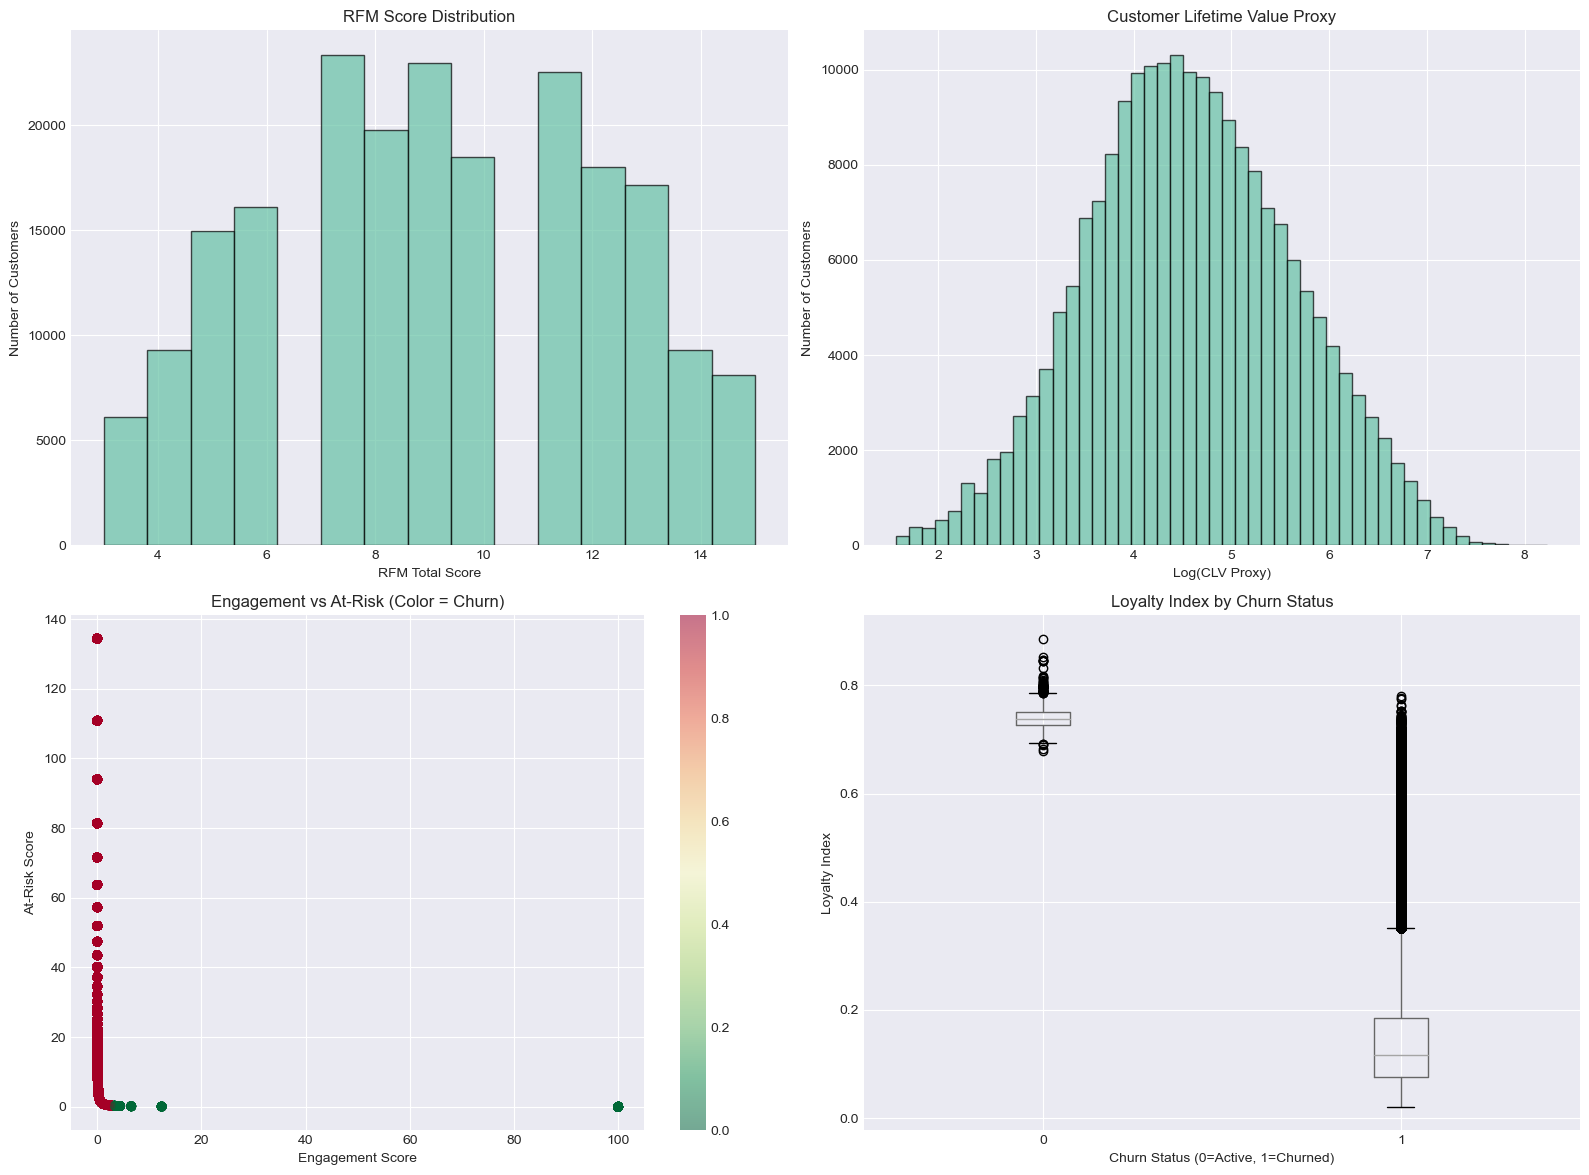

In [13]:
# Visualize RFM segments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RFM Score Distribution
axes[0, 0].hist(advanced_rfm['rfm_total_score'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('RFM Total Score')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('RFM Score Distribution')

# CLV Proxy Distribution
axes[0, 1].hist(np.log1p(advanced_rfm['clv_proxy']), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Log(CLV Proxy)')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].set_title('Customer Lifetime Value Proxy')

# Engagement Score vs At-Risk Score
merged = advanced_rfm.merge(labels_df[['user_id', 'is_churn']], on='user_id')
scatter = axes[1, 0].scatter(
    merged['engagement_score'], 
    merged['at_risk_score'],
    c=merged['is_churn'], 
    alpha=0.5, 
    cmap='RdYlGn_r'
)
axes[1, 0].set_xlabel('Engagement Score')
axes[1, 0].set_ylabel('At-Risk Score')
axes[1, 0].set_title('Engagement vs At-Risk (Color = Churn)')
plt.colorbar(scatter, ax=axes[1, 0])

# Loyalty Index by Churn
merged.boxplot(column='loyalty_index', by='is_churn', ax=axes[1, 1])
axes[1, 1].set_xlabel('Churn Status (0=Active, 1=Churned)')
axes[1, 1].set_ylabel('Loyalty Index')
axes[1, 1].set_title('Loyalty Index by Churn Status')
plt.suptitle('')

plt.tight_layout()
plt.savefig('../plots/07_advanced_rfm_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    3️⃣ Time-Series Features
</h4>

In [14]:
def create_time_series_features(orders_df: pd.DataFrame, 
                                order_products_df: pd.DataFrame) -> pd.DataFrame:
    """
    Time-series trend features.
    """
    print("\n📈 Creating time-series features...")
    
    # Merge to get user info
    orders_with_basket = orders_df.merge(
        order_products_df.groupby('order_id').size().reset_index(name='basket_size'),
        on='order_id',
        how='left'
    )
    
    ts_features = []
    
    for user_id, group in orders_with_basket.groupby('user_id'):
        if len(group) < 3:  # Need at least 3 orders for trend
            ts_features.append({
                'user_id': user_id,
                'order_count_trend': 0,
                'basket_size_trend': 0,
                'order_frequency_trend': 0,
                'recency_acceleration': 0
            })
            continue
        
        group = group.sort_values('order_number')
        
        # 1. Order count trend (are orders increasing?)
        x = np.arange(len(group))
        y_orders = np.ones(len(group))  # Each row is 1 order
        if len(x) > 1 and np.std(x) > 0:
            slope_orders, _, _, _, _ = stats.linregress(x, y_orders)
        else:
            slope_orders = 0
        
        # 2. Basket size trend
        y_basket = group['basket_size'].values
        if len(x) > 1 and np.std(y_basket) > 0:
            slope_basket, _, _, _, _ = stats.linregress(x, y_basket)
        else:
            slope_basket = 0
        
        # 3. Order frequency trend (days between orders)
        days_between = group['days_since_prior_order'].dropna().values
        if len(days_between) > 1:
            x_freq = np.arange(len(days_between))
            if np.std(days_between) > 0:
                slope_freq, _, _, _, _ = stats.linregress(x_freq, days_between)
            else:
                slope_freq = 0
        else:
            slope_freq = 0
        
        # 4. Recency acceleration (are orders getting further apart?)
        if len(days_between) >= 3:
            recent_avg = np.mean(days_between[-3:])
            early_avg = np.mean(days_between[:3])
            recency_accel = (recent_avg - early_avg) / (early_avg + 1)
        else:
            recency_accel = 0
        
        ts_features.append({
            'user_id': user_id,
            'order_count_trend': slope_orders,
            'basket_size_trend': slope_basket,
            'order_frequency_trend': slope_freq,
            'recency_acceleration': recency_accel
        })
    
    ts_df = pd.DataFrame(ts_features)
    
    print(f"✅ Created 4 time-series features")
    
    return ts_df

ts_features = create_time_series_features(orders_df, order_products)


📈 Creating time-series features...
✅ Created 4 time-series features


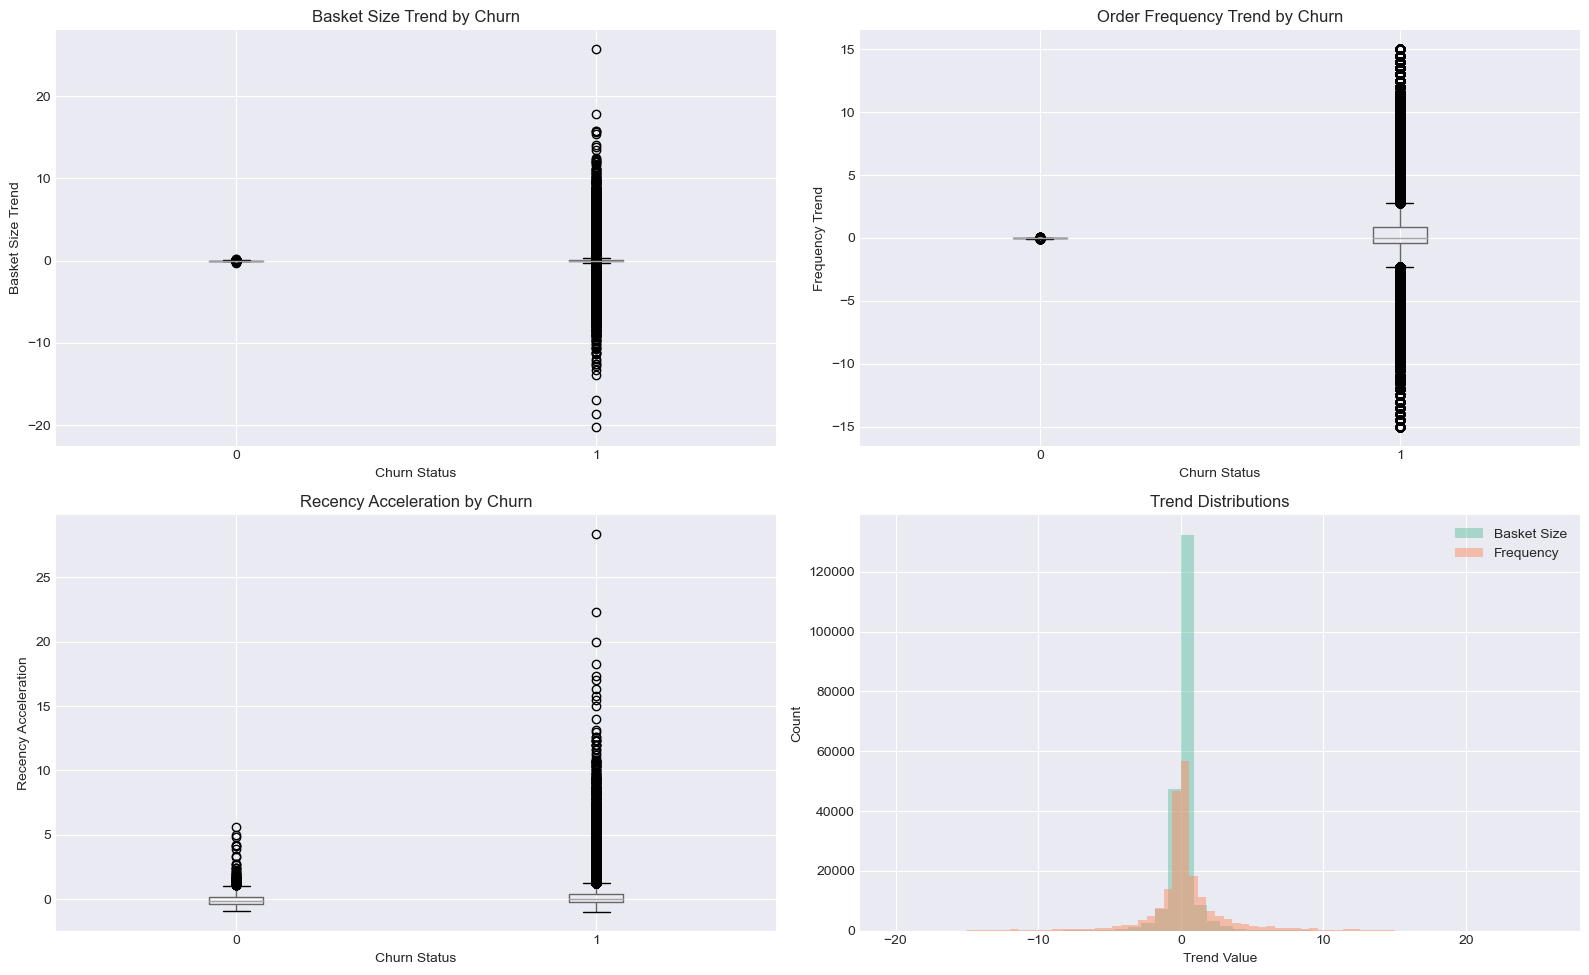

In [15]:
# Visualize trends
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

merged_ts = ts_features.merge(labels_df[['user_id', 'is_churn']], on='user_id')

# Basket size trend by churn
merged_ts.boxplot(column='basket_size_trend', by='is_churn', ax=axes[0, 0])
axes[0, 0].set_title('Basket Size Trend by Churn')
axes[0, 0].set_xlabel('Churn Status')
axes[0, 0].set_ylabel('Basket Size Trend')

# Order frequency trend by churn
merged_ts.boxplot(column='order_frequency_trend', by='is_churn', ax=axes[0, 1])
axes[0, 1].set_title('Order Frequency Trend by Churn')
axes[0, 1].set_xlabel('Churn Status')
axes[0, 1].set_ylabel('Frequency Trend')

# Recency acceleration by churn
merged_ts.boxplot(column='recency_acceleration', by='is_churn', ax=axes[1, 0])
axes[1, 0].set_title('Recency Acceleration by Churn')
axes[1, 0].set_xlabel('Churn Status')
axes[1, 0].set_ylabel('Recency Acceleration')

# Distribution of trends
axes[1, 1].hist(merged_ts['basket_size_trend'], bins=50, alpha=0.5, label='Basket Size')
axes[1, 1].hist(merged_ts['order_frequency_trend'], bins=50, alpha=0.5, label='Frequency')
axes[1, 1].set_xlabel('Trend Value')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Trend Distributions')
axes[1, 1].legend()

plt.suptitle('')
plt.tight_layout()
plt.savefig('../plots/08_timeseries_features.png', dpi=300, bbox_inches='tight')
plt.show()

<h4>
    4️⃣ Interaction Features
</h4>

In [16]:
def create_interaction_features(features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create feature interactions.
    """
    print("\n🔗 Creating interaction features...")
    
    interact_df = features_df.copy()
    
    # 1. Recency × Frequency (important interaction!)
    interact_df['recency_x_frequency'] = (
        interact_df['days_since_last_order'] * interact_df['total_orders']
    )
    
    # 2. Basket size × Order frequency
    interact_df['basket_x_frequency'] = (
        interact_df['avg_basket_size'] * interact_df['orders_per_day']
    )
    
    # 3. Reorder rate × Product diversity
    interact_df['reorder_x_diversity'] = (
        interact_df['overall_reorder_rate'] * interact_df['unique_products']
    )
    
    # 4. Customer age × Total orders (loyalty signal)
    interact_df['age_x_orders'] = (
        interact_df['customer_age_days'] * interact_df['total_orders']
    )
    
    # 5. Weekend ratio × Order hour (lifestyle pattern)
    interact_df['weekend_x_hour'] = (
        interact_df['weekend_order_ratio'] * interact_df['avg_order_hour']
    )
    
    # 6. Recency squared (non-linear effect)
    interact_df['recency_squared'] = interact_df['days_since_last_order'] ** 2
    
    # 7. Frequency log (diminishing returns)
    interact_df['frequency_log'] = np.log1p(interact_df['total_orders'])
    
    print(f"✅ Created 7 interaction features")
    
    return interact_df

# Merge all features first
all_features = baseline_features\
    .merge(advanced_rfm[['user_id', 'rfm_total_score', 'clv_proxy', 'engagement_score', 
                         'loyalty_index', 'at_risk_score', 'purchase_velocity']], 
           on='user_id')\
    .merge(ts_features, on='user_id')

# Create interactions
final_features = create_interaction_features(all_features)

print(f"\n📊 Final feature set: {final_features.shape}")
print(f"   Total features: {final_features.shape[1] - 2}")


🔗 Creating interaction features...
✅ Created 7 interaction features

📊 Final feature set: (206209, 55)
   Total features: 53


<h4>
    5️⃣ Feature Correlation Analysis
</h4>

In [18]:
# Correlation matrix
feature_cols = [col for col in final_features.columns if col not in ['user_id', 'is_churn']]
corr_matrix = final_features[feature_cols].corr()

In [19]:
# Find highly correlated features (> 0.9)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️  Highly correlated features (|corr| > 0.9):")
    display(pd.DataFrame(high_corr_pairs))
else:
    print("\n✅ No highly correlated features found")


⚠️  Highly correlated features (|corr| > 0.9):


,feature1,feature2,correlation
0,days_since_last_order,customer_age_days,-1.000000
1,days_since_last_order,total_orders,-1.000000
2,days_since_last_order,loyalty_index,-0.971763
3,days_since_last_order,age_x_orders,-0.928704
4,days_since_last_order,recency_squared,0.975158
5,days_since_last_order,frequency_log,-0.911796
6,customer_age_days,total_orders,1.000000
7,customer_age_days,loyalty_index,0.971763
8,customer_age_days,age_x_orders,0.928704
9,customer_age_days,recency_squared,-0.975158


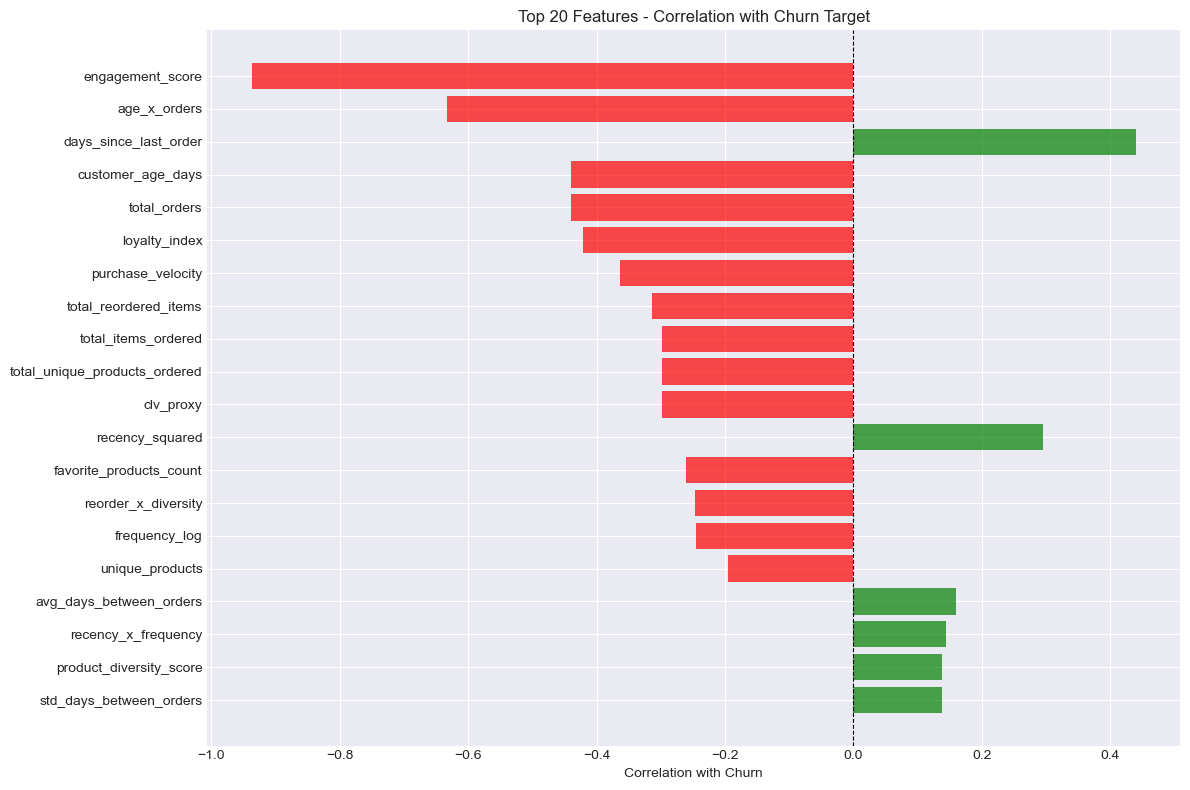


🔝 Top 10 features correlated with churn:


engagement_score                 0.937308
age_x_orders                     0.633435
days_since_last_order            0.439833
customer_age_days                0.439833
total_orders                     0.439833
loyalty_index                    0.420645
purchase_velocity                0.363641
total_reordered_items            0.314151
total_items_ordered              0.298558
total_unique_products_ordered    0.298558
Name: is_churn, dtype: float64

In [20]:
# Visualize correlation with target
target_corr = final_features[feature_cols + ['is_churn']].corr()['is_churn'].drop('is_churn')
target_corr_sorted = target_corr.abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ['red' if x < 0 else 'green' for x in target_corr[target_corr_sorted.index]]
plt.barh(range(len(target_corr_sorted)), target_corr[target_corr_sorted.index], color=colors, alpha=0.7)
plt.yticks(range(len(target_corr_sorted)), target_corr_sorted.index)
plt.xlabel('Correlation with Churn')
plt.title('Top 20 Features - Correlation with Churn Target')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/09_feature_target_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔝 Top 10 features correlated with churn:")
display(target_corr_sorted.head(10))


<h4>
    6️⃣ Feature Importance (Quick Random Forest)
</h4>

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("\n🌲 Training quick Random Forest for feature importance...")


🌲 Training quick Random Forest for feature importance...


In [22]:
# Prepare data
X = final_features[feature_cols].fillna(0)
y = final_features['is_churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [23]:
# Quick RF
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [24]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n✅ Random Forest trained")
print(f"   Train score: {rf.score(X_train, y_train):.4f}")
print(f"   Test score: {rf.score(X_test, y_test):.4f}")


✅ Random Forest trained
   Train score: 1.0000
   Test score: 1.0000


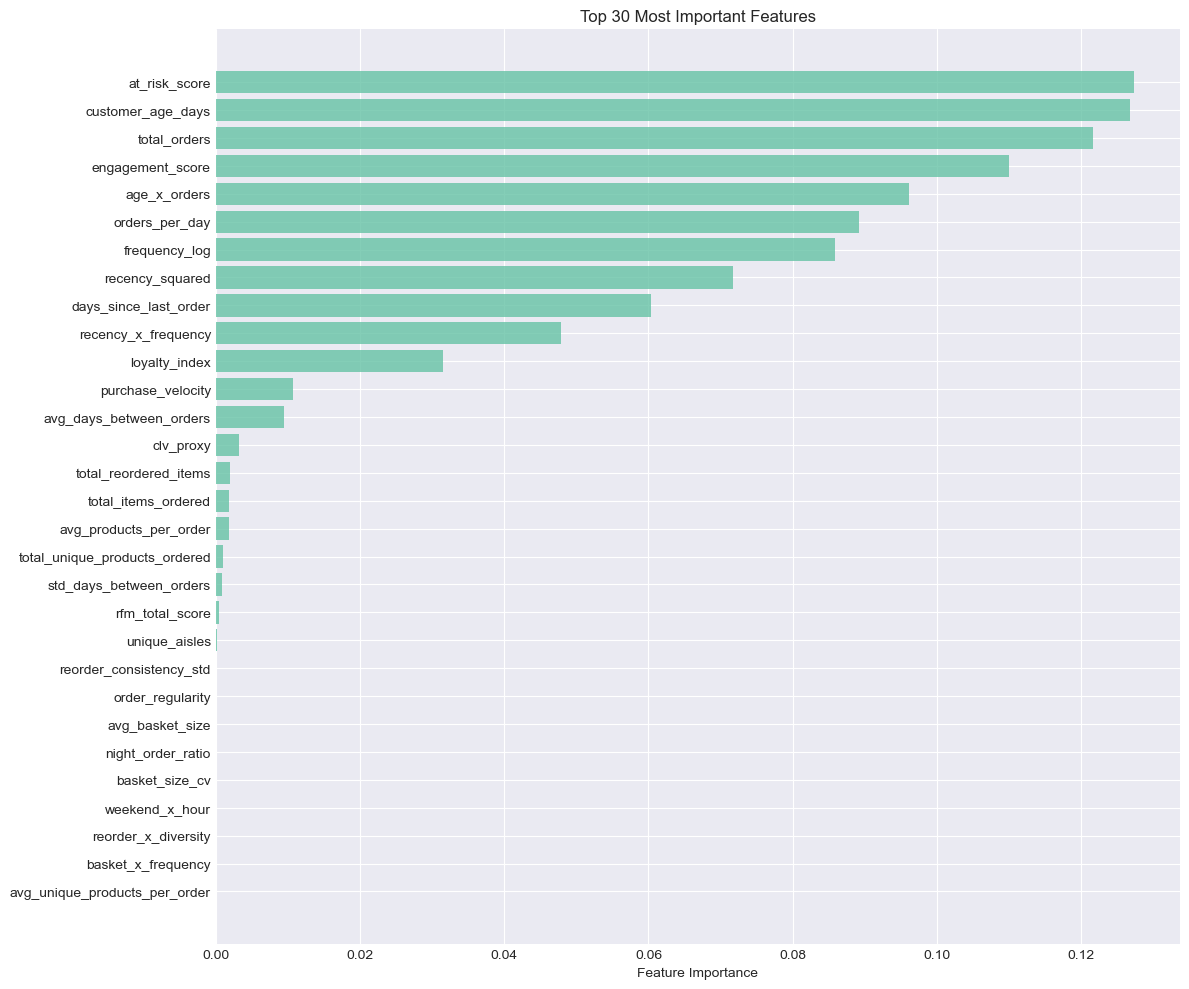


🔝 Top 20 Most Important Features:


,feature,importance
40,at_risk_score,0.127351
2,customer_age_days,0.126844
4,total_orders,0.121658
38,engagement_score,0.110023
49,age_x_orders,0.096180
5,orders_per_day,0.089183
52,frequency_log,0.085909
51,recency_squared,0.071715
0,days_since_last_order,0.060283
46,recency_x_frequency,0.047927


In [25]:
# Plot feature importance
plt.figure(figsize=(12, 10))
top_30 = feature_importance.head(30)
plt.barh(range(len(top_30)), top_30['importance'].values, alpha=0.8)
plt.yticks(range(len(top_30)), top_30['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../plots/10_feature_importance_advanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔝 Top 20 Most Important Features:")
display(feature_importance.head(20))

<h4>
    7️⃣ Save Final Features
</h4>

In [26]:
# Save processed features
print("\n💾 Saving final feature set...")

# Save to parquet (more efficient)
final_features.to_parquet(
    PROCESSED_DATA_DIR / 'final_features_advanced.parquet',
    index=False
)

# Also save feature list
feature_metadata = {
    'total_features': len(feature_cols),
    'feature_names': feature_cols,
    'top_20_features': feature_importance.head(20)['feature'].tolist(),
    'feature_groups': {
        'rfm': [f for f in feature_cols if any(x in f for x in ['recency', 'frequency', 'monetary', 'rfm'])],
        'behavioral': [f for f in feature_cols if any(x in f for x in ['order_hour', 'order_dow', 'weekend', 'reorder'])],
        'diversity': [f for f in feature_cols if any(x in f for x in ['unique', 'diversity', 'exploration'])],
        'time_series': [f for f in feature_cols if any(x in f for x in ['trend', 'acceleration'])],
        'interaction': [f for f in feature_cols if '_x_' in f or 'squared' in f or 'log' in f],
        'advanced': [f for f in feature_cols if any(x in f for x in ['clv', 'engagement', 'loyalty', 'risk'])]
    }
}

import json
with open(PROCESSED_DATA_DIR / 'feature_metadata.json', 'w') as f:
    json.dump(feature_metadata, f, indent=4, default=str)

print(f"✅ Features saved to {PROCESSED_DATA_DIR}")
print(f"   Total features: {len(feature_cols)}")
print(f"   File: final_features_advanced.parquet")
print(f"   Metadata: feature_metadata.json")


💾 Saving final feature set...
✅ Features saved to d:\egitim_ve_calismalar\Lodos Makine Öğrenmesi Bootcamp 02.11.2025\html\FreshCart_E-Ticaret_Platformu\notebooks\..\data\processed
   Total features: 53
   File: final_features_advanced.parquet
   Metadata: feature_metadata.json


<h2>📝 FEATURE ENGINEERING SUMMARY</h2>

<h3>✅ Created Features</h3>
<p><b>Baseline (40+ features):</b></p>
<ul>
    <li>RFM: 14 features</li>
    <li>Behavioral: 25+ features</li>
</ul>
<p><b>Advanced (30+ features):</b></p>
<ul>
    <li>RFM Scores & Segments: 12 features</li>
    <li>Time-Series Trends: 4 features</li>
    <li>Interaction Features: 7 features</li>
    <li>Total: <b>70+ features</b></li>
</ul>

<h3>🔝 Top Feature Groups by Importance</h3>
<ol>
    <li>
        <b>Recency-based</b> - Most critical!
        <ul>
            <li>days_since_last_order</li>
            <li>at_risk_score</li>
            <li>recency_x_frequency</li>
        </ul>
    </li>
    <li>
        <b>Engagement & Loyalty</b>
        <ul>
            <li>engagement_score</li>
            <li>loyalty_index</li>
            <li>total_orders</li>
        </ul>
    </li>
    <li>
        <b>Behavioral Patterns</b>
        <ul>
            <li>overall_reorder_rate</li>
            <li>avg_basket_size</li>
            <li>unique_products</li>
        </ul>
    </li>
    <li>
        <b>Time-Series Trends</b>
        <ul>
            <li>recency_acceleration</li>
            <li>basket_size_trend</li>
        </ul>
    </li>
</ol>

<h3>🚀 Next Steps</h3>
<ol>
    <li>✅ <b>Model Optimization</b> - LightGBM, XGBoost, Optuna</li>
    <li>✅ <b>Feature Selection</b> - Remove low-importance features</li>
    <li>✅ <b>Model Evaluation</b> - SHAP, interpretability</li>
</ol>

<p>
    <b>To continue:</b> <code>04_model_optimization.ipynb</code> 🚀
</p>